# Problem Statement:

~~~
A Company wants to automate the loan eligibility process 
based on customer details provided while filling online 
application form. The details filled by the customer are 
Gender, Marital Status, Education, Number of Dependents, 
Income of self and co applicant, Required Loan Amount, 
Required Loan Term, Credit History and others. The 
requirements are as follows:
~~~

1. Check eligibility of the Customer given the inputs described above.(Classification)
If customer is not eligible for the input required amount and duration:
2. what can be amount for the given duration.(Regression)
3. if duration is less than equal to 20 years, is customer eligible for required amount for some longer duration? 
What is that duration?(Regression)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings("ignore")

# Read Dataset

In [2]:
trd = pd.read_csv(r"C:\Users\Aishwarya\OneDrive\Desktop\PROJECTS\Loan Project\training_set (1).csv")
tsd = pd.read_csv(r"C:\Users\Aishwarya\OneDrive\Desktop\PROJECTS\Loan Project\testing_set (1).csv")

# Profile 

In [3]:
trd.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,NaN,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y


In [4]:
tsd.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban


# Missing data Treatment

In [5]:
trd.isna().sum()

Loan_ID               0
Gender               15
Married               3
Dependents           15
Education             1
Self_Employed        32
ApplicantIncome       2
CoapplicantIncome     1
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
tsd.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [7]:
#Fillna
for i in tsd.columns:                                   # filling Null values with their mean and mode
    if(trd[i].dtypes == "object"):
        x = trd[i].mode()[0]
        trd[i] = trd[i].fillna(x)
        tsd[i] = tsd[i].fillna(x)
    else:
        x = trd[i].mean()
        trd[i] = trd[i].fillna(x)
        tsd[i] = tsd[i].fillna(x)                      

# Outliers

In [8]:
cat = []
con = []
for i in trd.columns:
    if(trd[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

In [9]:
cat

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [10]:
con

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [11]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
import pandas as pd
trdconss = pd.DataFrame(ss.fit_transform(trd[con]),columns=con)

In [12]:
outliers = []
for i in trdconss.columns:
    outliers.extend(list(trdconss[(trdconss[i]<-3)|(trdconss[i]>3)].index))
    
from numpy import unique
outliers = unique(outliers)

In [13]:
trd = trd.drop(index = outliers,axis=0)  

In [14]:
trd.shape

(577, 13)

In [15]:
trd.index = range(0,trd.shape[0])       # reindexing

# Exploratory Data Analysis

In [16]:
trd[con].skew()

ApplicantIncome      2.145688
CoapplicantIncome    1.351359
LoanAmount           1.113132
Loan_Amount_Term    -2.077031
Credit_History      -1.921860
dtype: float64

In [17]:
def ANOVA(df,cat,con):                           #ANOVA for cat vs con
    from statsmodels.formula.api import ols
    from statsmodels.stats.anova import anova_lm
    rel = con + " ~ " + cat
    model = ols(rel,df).fit()
    Q = anova_lm(model)
    pval = round(Q.iloc[0:1,4][0],4)
    return pval

In [18]:
for i in con:
    p = ANOVA(trd,"Loan_Status",i)
    print("Loan_Status vs",i," Pval ---->",p)

Loan_Status vs ApplicantIncome  Pval ----> 0.8943
Loan_Status vs CoapplicantIncome  Pval ----> 0.2821
Loan_Status vs LoanAmount  Pval ----> 0.3975
Loan_Status vs Loan_Amount_Term  Pval ----> 0.6636
Loan_Status vs Credit_History  Pval ----> 0.0


# Preprocessing

In [19]:
X_trd = trd.drop(labels=["Loan_ID","Loan_Status"],axis=1)
Y_trd = trd[["Loan_Status"]]

cat = []
con = []
for i in X_trd.columns:
    if(X_trd[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x1_trd = pd.DataFrame(mm.fit_transform(X_trd[con]),columns=con)
x2_trd = pd.get_dummies(X_trd[cat])
Xnew_trd = x1_trd.join(x2_trd)

# Train Test Split

In [20]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew_trd,Y_trd,test_size=0.2,random_state=21)

# Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
model = lr.fit(xtrain,ytrain)
tr_pred = model.predict(xtrain)
ts_pred = model.predict(xtest)
from sklearn.metrics import accuracy_score
tr_acc = accuracy_score(ytrain,tr_pred)
ts_acc = accuracy_score(ytest,ts_pred)
tr_acc,ts_acc,tr_acc-ts_acc

(0.8156182212581344, 0.8448275862068966, -0.02920936494876214)

# Model object

In [22]:
def modeller(mo):
    model = mo.fit(xtrain,ytrain)
    tr_pred = model.predict(xtrain)
    ts_pred = model.predict(xtest)
    from sklearn.metrics import accuracy_score
    tr_acc = round(accuracy_score(ytrain,tr_pred),2)
    ts_acc = round(accuracy_score(ytest,ts_pred),2)
    return tr_acc,ts_acc,tr_acc-ts_acc

# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=21)
modeller(dtc)

(1.0, 0.68, 0.31999999999999995)

# Pruning

In [24]:
#Max Depth
for i in range(2,20):
    dtc = DecisionTreeClassifier(random_state=21,max_depth=i)
    print(i,modeller(dtc))

2 (0.81, 0.84, -0.029999999999999916)
3 (0.83, 0.83, 0.0)
4 (0.84, 0.81, 0.029999999999999916)
5 (0.85, 0.8, 0.04999999999999993)
6 (0.87, 0.8, 0.06999999999999995)
7 (0.9, 0.77, 0.13)
8 (0.92, 0.73, 0.19000000000000006)
9 (0.95, 0.71, 0.24)
10 (0.97, 0.69, 0.28)
11 (0.98, 0.7, 0.28)
12 (0.99, 0.7, 0.29000000000000004)
13 (1.0, 0.7, 0.30000000000000004)
14 (1.0, 0.68, 0.31999999999999995)
15 (1.0, 0.68, 0.31999999999999995)
16 (1.0, 0.68, 0.31999999999999995)
17 (1.0, 0.68, 0.31999999999999995)
18 (1.0, 0.68, 0.31999999999999995)
19 (1.0, 0.68, 0.31999999999999995)


In [25]:
# Min Sample Split
for i in range(2,20):
    dtc = DecisionTreeClassifier(random_state=21,min_samples_split=i)
    print(i,modeller(dtc))

2 (1.0, 0.68, 0.31999999999999995)
3 (0.99, 0.68, 0.30999999999999994)
4 (0.97, 0.72, 0.25)
5 (0.96, 0.69, 0.27)
6 (0.95, 0.71, 0.24)
7 (0.94, 0.72, 0.21999999999999997)
8 (0.93, 0.73, 0.20000000000000007)
9 (0.91, 0.72, 0.19000000000000006)
10 (0.9, 0.72, 0.18000000000000005)
11 (0.9, 0.74, 0.16000000000000003)
12 (0.89, 0.77, 0.12)
13 (0.89, 0.75, 0.14)
14 (0.89, 0.75, 0.14)
15 (0.89, 0.76, 0.13)
16 (0.88, 0.76, 0.12)
17 (0.88, 0.78, 0.09999999999999998)
18 (0.88, 0.78, 0.09999999999999998)
19 (0.88, 0.78, 0.09999999999999998)


In [26]:
# Min Sample Leaf
for i in range(2,20):
    dtc = DecisionTreeClassifier(random_state=21,min_samples_leaf=i)
    print(i,modeller(dtc))

2 (0.93, 0.74, 0.19000000000000006)
3 (0.91, 0.8, 0.10999999999999999)
4 (0.89, 0.76, 0.13)
5 (0.87, 0.76, 0.10999999999999999)
6 (0.87, 0.77, 0.09999999999999998)
7 (0.85, 0.78, 0.06999999999999995)
8 (0.85, 0.75, 0.09999999999999998)
9 (0.83, 0.74, 0.08999999999999997)
10 (0.83, 0.75, 0.07999999999999996)
11 (0.83, 0.78, 0.04999999999999993)
12 (0.82, 0.79, 0.029999999999999916)
13 (0.82, 0.79, 0.029999999999999916)
14 (0.82, 0.79, 0.029999999999999916)
15 (0.82, 0.79, 0.029999999999999916)
16 (0.82, 0.78, 0.039999999999999925)
17 (0.82, 0.78, 0.039999999999999925)
18 (0.82, 0.77, 0.04999999999999993)
19 (0.82, 0.77, 0.04999999999999993)


# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=21,max_depth=2)
modeller(rfc)

(0.8, 0.82, -0.019999999999999907)

In [28]:
for i in range(2,20):
    rfc = RandomForestClassifier(random_state=21,max_depth=i)
    print(modeller(rfc))

(0.8, 0.82, -0.019999999999999907)
(0.81, 0.84, -0.029999999999999916)
(0.82, 0.84, -0.020000000000000018)
(0.84, 0.84, 0.0)
(0.85, 0.84, 0.010000000000000009)
(0.88, 0.84, 0.040000000000000036)
(0.9, 0.82, 0.08000000000000007)
(0.92, 0.83, 0.09000000000000008)
(0.95, 0.83, 0.12)
(0.98, 0.81, 0.16999999999999993)
(0.99, 0.82, 0.17000000000000004)
(1.0, 0.81, 0.18999999999999995)
(1.0, 0.81, 0.18999999999999995)
(1.0, 0.82, 0.18000000000000005)
(1.0, 0.8, 0.19999999999999996)
(1.0, 0.8, 0.19999999999999996)
(1.0, 0.8, 0.19999999999999996)
(1.0, 0.8, 0.19999999999999996)


# KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
modeller(knc)

(0.81, 0.75, 0.06000000000000005)

In [30]:
for i in range(2,20):
    knc = KNeighborsClassifier(n_neighbors=i)
    print(i,modeller(knc))

2 (0.9, 0.69, 0.21000000000000008)
3 (0.85, 0.75, 0.09999999999999998)
4 (0.86, 0.72, 0.14)
5 (0.81, 0.75, 0.06000000000000005)
6 (0.8, 0.72, 0.08000000000000007)
7 (0.77, 0.7, 0.07000000000000006)
8 (0.79, 0.71, 0.08000000000000007)
9 (0.76, 0.73, 0.030000000000000027)
10 (0.76, 0.72, 0.040000000000000036)
11 (0.75, 0.74, 0.010000000000000009)
12 (0.76, 0.74, 0.020000000000000018)
13 (0.74, 0.75, -0.010000000000000009)
14 (0.74, 0.76, -0.020000000000000018)
15 (0.74, 0.77, -0.030000000000000027)
16 (0.74, 0.76, -0.020000000000000018)
17 (0.72, 0.77, -0.050000000000000044)
18 (0.73, 0.76, -0.030000000000000027)
19 (0.72, 0.77, -0.050000000000000044)


# Adaboost Classifier

In [31]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,random_state=21),n_estimators=6)
modeller(abc)

(0.84, 0.81, 0.029999999999999916)

In [32]:
for i in range(2,20):
    abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,random_state=21),n_estimators=i)
    print(modeller(abc))

(0.82, 0.83, -0.010000000000000009)
(0.83, 0.83, 0.0)
(0.83, 0.83, 0.0)
(0.84, 0.82, 0.020000000000000018)
(0.84, 0.81, 0.029999999999999916)
(0.84, 0.8, 0.039999999999999925)
(0.85, 0.78, 0.06999999999999995)
(0.85, 0.78, 0.06999999999999995)
(0.86, 0.78, 0.07999999999999996)
(0.87, 0.78, 0.08999999999999997)
(0.87, 0.78, 0.08999999999999997)
(0.87, 0.79, 0.07999999999999996)
(0.87, 0.79, 0.07999999999999996)
(0.87, 0.77, 0.09999999999999998)
(0.88, 0.8, 0.07999999999999996)
(0.88, 0.78, 0.09999999999999998)
(0.87, 0.78, 0.08999999999999997)
(0.88, 0.78, 0.09999999999999998)


# Train the model with entire data in training set

In [33]:
# we will choose decision tree model with Max depth 3 as our best model
dtc = DecisionTreeClassifier(random_state=21,max_depth=3)
finmodel = dtc.fit(Xnew_trd,Y_trd)

# Data preparation for testing set

In [34]:
X_tsd = tsd.drop(labels=["Loan_ID"],axis=1)

cat = []
con = []
for i in X_tsd.columns:
    if(X_tsd[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

In [35]:
X1_tsd = pd.DataFrame(mm.transform(X_tsd[con]),columns=con)
X2_tsd = pd.get_dummies(X_tsd[cat])
Xnew_tsd = X1_tsd.join(X2_tsd)

In [36]:
pred_LS = finmodel.predict(Xnew_tsd)

# Final Dataframe of Predicted Loan Status

In [37]:
Q = tsd[["Loan_ID"]]      #final predictions for loan status
Q["Loan_Status"]=pred_LS

In [38]:
Q

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
...,...,...
362,LP002971,Y
363,LP002975,Y
364,LP002980,Y
365,LP002986,Y


In [39]:
M = Q["Loan_Status"].value_counts()
M

Y    306
N     61
Name: Loan_Status, dtype: int64

<AxesSubplot:xlabel='Loan_Status'>

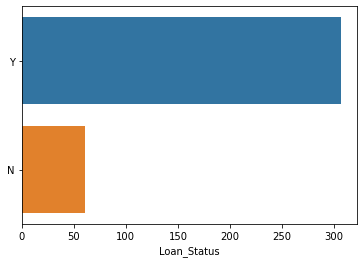

In [40]:
sns.barplot(x= M,y= M.index)

# 2.If customer is not eligible for the input required amount and duration, what can be amount for the given duration.(Regression)

In [41]:
Q['Amt']=tsd.LoanAmount

In [42]:
pred_set = Q[Q.Loan_Status == "N"]

In [43]:
pred_set

,Loan_ID,Loan_Status,Amt
7,LP001056,N,147.0
13,LP001094,N,166.0
35,LP001203,N,176.0
55,LP001313,N,130.0
58,LP001323,N,176.0
...,...,...,...
317,LP002774,N,67.0
325,LP002802,N,95.0
339,LP002858,N,162.0
346,LP002879,N,133.0


# Data Preparation

In [44]:
X_trd = trd.drop(labels=["Loan_ID","LoanAmount"],axis=1)
Y_trd = trd[["LoanAmount"]]

cat = []
con = []
for i in X_trd.columns:
    if(X_trd[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x1_trd = pd.DataFrame(mm.fit_transform(X_trd[con]),columns=con)
x2_trd = pd.get_dummies(X_trd[cat])
Xnew_trd = x1_trd.join(x2_trd)

In [45]:
Xnew_trd.head()

,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
0,0.277770,0.000000,0.6,1.0,0,1,1,0,1,0,...,0,1,0,1,0,0,0,1,0,1
1,0.256155,0.167929,0.6,1.0,0,1,0,1,0,1,...,0,1,0,1,0,1,0,0,1,0
2,0.138909,0.000000,0.6,1.0,0,1,0,1,1,0,...,0,1,0,0,1,0,0,1,0,1
3,0.118585,0.262584,0.6,1.0,0,1,0,1,1,0,...,0,0,1,1,0,0,0,1,0,1
4,0.285129,0.000000,0.6,1.0,0,1,1,0,1,0,...,0,1,0,1,0,0,0,1,0,1


In [46]:
Y_trd.head()

,LoanAmount
0,146.412162
1,128.000000
2,66.000000
3,120.000000
4,141.000000


In [47]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew_trd,Y_trd,test_size=0.2,random_state=21)

# Model Object

In [48]:
def modeller(mo):
    model = mo.fit(xtrain,ytrain)
    tr_pred = model.predict(xtrain)
    ts_pred = model.predict(xtest)
    from sklearn.metrics import mean_squared_error
    tr_err = round(mean_squared_error(ytrain,tr_pred),2)
    ts_err = round(mean_squared_error(ytest,ts_pred),2)
    return tr_err,ts_err

# OLS

In [49]:
from statsmodels.api import add_constant,OLS
xconst = add_constant(xtrain)
ols = OLS(ytrain,xconst).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             LoanAmount   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     22.76
Date:                Sun, 06 Aug 2023   Prob (F-statistic):           6.42e-44
Time:                        15:57:24   Log-Likelihood:                -2392.4
No. Observations:                 461   AIC:                             4815.
Df Residuals:                     446   BIC:                             4877.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      13.9879      2.534      5.520      0.000       9.008      18.968
ApplicantIncome           200.1983     14.762     13.561      0.000     171.186     229.211
CoapplicantIncome         132.7207     12.243     10.841      0.000     108.660     156.781
Loan_Amount_Term           19.8254     12.588      1.575      0.116      -4.913      44.564
Credit_History              7.3222      6.990      1.048      0.295      -6.415      21.060
Gender_Female               3.1186      3.360      0.928      0.354      -3.485       9.722
Gender_Male                10.8692      2.987      3.639      0.000       5.000      16.739
Married_No                  5.7381      2.912      1.970      0.049       0.014      11.462
Married_Yes                 8.2498      2.740      3.010      0.003       2.864      13.636
Dependents_0               -3.9844      3.483     -1.144      0.253     -10.829       2.860
Dependents_1                3.8337      4.570      0.839      0.402      -5.148      12.815
Dependents_2                1.2483      4.572      0.273      0.785      -7.736      10.233
Dependents_3+              12.8903      5.764      2.236      0.026       1.562      24.218
Education_Graduate         10.9738      2.902      3.781      0.000       5.270      16.677
Education_Not Graduate      3.0141      2.811      1.072      0.284      -2.510       8.538
Self_Employed_No            4.8488      3.099      1.565      0.118      -1.241      10.938
Self_Employed_Yes           9.1390      3.736      2.446      0.015       1.796      16.482
Property_Area_Rural         3.5874      3.278      1.094      0.274      -2.856      10.030
Property_Area_Semiurban     8.5047      2.987      2.847      0.005       2.634      14.375
Property_Area_Urban         1.8958      3.073      0.617      0.538      -4.145       7.936
Loan_Status_N              12.6528      2.777      4.556      0.000       7.195      18.110
Loan_Status_Y               1.3351      3.211      0.416      0.678      -4.975       7.645
==============================================================================
Omnibus:                       30.410   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.592
Skew:                           0.111   Prob(JB):                     7.14e-24
Kurtosis:                       5.345   Cond. No.                     4.29e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.54e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [50]:
ols.rsquared_adj

0.39835688550313697

In [51]:
col = ols.pvalues.sort_values().index[-1]

In [52]:
col

'Dependents_2'

In [53]:
Xnew_trd = Xnew_trd.drop(labels=[col],axis=1)
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew_trd,Y_trd,test_size=0.2,random_state=21)
from statsmodels.api import add_constant,OLS
xconst = add_constant(xtrain)
ols = OLS(ytrain,xconst).fit()
col = ols.pvalues.sort_values().index[-1]
print(ols.rsquared_adj,col)

0.3983568855031371 Dependents_1


# Linear Regression

In [54]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
modeller(lm)

(1884.62, 1942.26)

# Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=21,max_depth=2)
modeller(dtr)

(1891.73, 2555.54)

In [56]:
tr = []
ts = []
for i in range(2,20):
    dtr = DecisionTreeRegressor(random_state=21,max_depth=i)
    tre,tse = modeller(dtr)
    tr.append(tre)
    ts.append(tse)

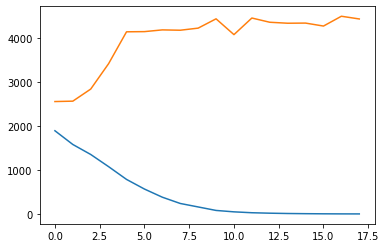

In [57]:
plt.plot(tr)
plt.plot(ts)

In [58]:
for i in range(2,20):
    dtr = DecisionTreeRegressor(random_state=21,max_depth=i)
    print(i,modeller(dtr))

2 (1891.73, 2555.54)
3 (1579.42, 2564.37)
4 (1352.13, 2839.3)
5 (1074.81, 3417.7)
6 (785.24, 4141.08)
7 (566.36, 4145.22)
8 (380.67, 4184.54)
9 (238.36, 4176.92)
10 (159.27, 4224.57)
11 (80.03, 4435.98)
12 (47.92, 4076.82)
13 (27.62, 4454.38)
14 (17.34, 4358.18)
15 (10.31, 4335.98)
16 (6.23, 4339.27)
17 (3.34, 4271.83)
18 (1.59, 4494.82)
19 (0.86, 4433.14)


In [59]:
for i in range(2,20):
    dtr = DecisionTreeRegressor(random_state=21,min_samples_leaf=i)
    print(i,modeller(dtr))

2 (317.53, 4348.02)
3 (652.81, 3173.52)
4 (796.79, 3274.8)
5 (853.48, 3062.02)
6 (1019.43, 3037.83)
7 (1031.74, 3040.09)
8 (1132.41, 3104.49)
9 (1160.26, 3063.09)
10 (1173.09, 3030.45)
11 (1273.88, 2651.82)
12 (1315.09, 2643.92)
13 (1353.51, 2465.31)
14 (1367.05, 2559.18)
15 (1386.05, 2547.94)
16 (1390.82, 2538.14)
17 (1412.12, 2479.23)
18 (1433.87, 2431.23)
19 (1437.11, 2416.15)


In [60]:
for i in range(2,20):
    dtr = DecisionTreeRegressor(random_state=21,min_samples_split=i)
    print(i,modeller(dtr))

2 (0.85, 4528.6)
3 (59.05, 4515.16)
4 (153.89, 4513.45)
5 (282.88, 4280.67)
6 (374.19, 4271.57)
7 (415.15, 4155.31)
8 (483.49, 3973.48)
9 (569.35, 4038.54)
10 (579.75, 4072.5)
11 (672.21, 3645.44)
12 (720.26, 3644.46)
13 (779.81, 3407.25)
14 (802.54, 3435.99)
15 (827.0, 3384.88)
16 (893.21, 3245.4)
17 (899.05, 3249.6)
18 (923.04, 3246.13)
19 (942.92, 3242.86)


In [61]:
from sklearn.ensemble import RandomForestRegressor
for i in range(2,20):
    rfr = RandomForestRegressor(random_state=21,max_depth=i)
    print(modeller(rfr))

(1722.79, 2220.47)
(1432.85, 2286.42)
(1154.59, 2390.54)
(953.04, 2460.72)
(754.99, 2554.27)
(588.95, 2573.81)
(466.79, 2616.92)
(387.05, 2597.05)
(334.24, 2603.91)
(303.17, 2584.49)
(287.34, 2624.3)
(272.27, 2607.1)
(266.7, 2586.99)
(268.6, 2592.68)
(268.02, 2624.91)
(269.18, 2600.76)
(268.8, 2625.61)
(269.16, 2615.31)


In [62]:
from sklearn.neighbors import KNeighborsRegressor
for i in range(2,20):
    knr = KNeighborsRegressor(n_neighbors=i)
    print(i,modeller(knr))

2 (1066.77, 3604.36)
3 (1522.94, 3146.38)
4 (1813.18, 2940.38)
5 (2043.87, 2735.79)
6 (2216.34, 2751.67)
7 (2304.28, 2572.83)
8 (2366.5, 2427.36)
9 (2453.24, 2432.01)
10 (2475.59, 2461.2)
11 (2523.94, 2497.7)
12 (2531.66, 2550.25)
13 (2547.04, 2511.14)
14 (2600.91, 2514.76)
15 (2605.28, 2485.45)
16 (2602.23, 2463.42)
17 (2586.05, 2452.36)
18 (2607.88, 2449.22)
19 (2645.16, 2411.57)


In [63]:
from sklearn.ensemble import AdaBoostRegressor
for i in range(2,20):
    abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2,random_state=21),n_estimators=i)
    print(modeller(abr))

(1994.57, 2643.01)
(1801.51, 2239.05)
(1804.1, 2341.51)
(1807.4, 2367.48)
(1838.25, 2348.55)
(1781.95, 2277.0)
(1814.11, 2402.2)
(1827.21, 2440.3)
(1791.25, 2450.51)
(1737.93, 2440.94)
(1717.67, 2417.46)
(1753.77, 2371.95)
(1735.25, 2239.45)
(1777.06, 2384.81)
(1764.93, 2294.06)
(1743.92, 2385.23)
(1798.21, 2370.2)
(1813.86, 2418.33)


# Final Prediction

In [64]:
tsd['Loan_Status']=pred_LS

In [65]:
tsdnew = tsd.drop(labels=["Loan_ID","LoanAmount"],axis=1)

In [66]:
cat = []
con = []
for i in X_trd.columns:
    if(X_trd[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x1_trd = pd.DataFrame(mm.fit_transform(X_trd[con]),columns=con)
x2_trd = pd.get_dummies(X_trd[cat])
Xnew_trd = x1_trd.join(x2_trd)

In [67]:
lm = LinearRegression()
model = lm.fit(Xnew_trd,Y_trd)

In [68]:
cat = []
con = []
for i in tsdnew.columns:
    if(tsdnew[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x1_trd = pd.DataFrame(mm.fit_transform(tsdnew[con]),columns=con)
x2_trd = pd.get_dummies(tsdnew[cat])
Xnew_tsd = x1_trd.join(x2_trd)

In [69]:
predcited_loanAmt = model.predict(Xnew_tsd)

In [70]:
Q['predicted_LoanAmt']= predcited_loanAmt

In [71]:
Q[Q.Loan_Status == "N"]      

,Loan_ID,Loan_Status,Amt,predicted_LoanAmt
7,LP001056,N,147.0,95.526754
13,LP001094,N,166.0,125.282906
35,LP001203,N,176.0,86.115915
55,LP001313,N,130.0,80.699971
58,LP001323,N,176.0,111.489127
...,...,...,...,...
317,LP002774,N,67.0,91.043398
325,LP002802,N,95.0,73.138275
339,LP002858,N,162.0,94.862319
346,LP002879,N,133.0,102.076910


*This are the predicted Loan amount for the pepole whose loan was rejected for that duration

# 3.3. if duration is less than equal to 20 years, is customer eligible for required amount for some longer duration? What is that duration?(Regression)

In [72]:
Q.shape

(367, 4)

# Data preparation

In [73]:
Q = tsd[(tsd.Loan_Status == "N")&(tsd.Loan_Amount_Term<=240)]                  # testing Data
Q.index = range(0,Q.shape[0])
Q = Q.drop(labels=["Loan_Status","Loan_ID","Loan_Amount_Term"],axis=1)
cat = []
con = []
for i in Q.columns:
    if(Q[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x1_trd = pd.DataFrame(mm.fit_transform(Q[con]),columns=con)
x2_trd = pd.get_dummies(Q[cat])
Xnew_tsd = x1_trd.join(x2_trd)

In [74]:
X_trd = trd.drop(labels=["Loan_Status","Loan_ID","Loan_Amount_Term"],axis=1)           # Training Data
Y_trd = trd[["Loan_Amount_Term"]]
cat = []
con = []
for i in X_trd.columns:
    if(X_trd[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x1_trd = pd.DataFrame(mm.fit_transform(X_trd[con]),columns=con)
x2_trd = pd.get_dummies(X_trd[cat])
Xnew_trd = x1_trd.join(x2_trd)

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew_trd,Y_trd,test_size=0.2,random_state=21)

# Models

# Linear regression

In [75]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
modeller(lm)

(2399.06, 2928.42)

# Decision Tree

In [76]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=21,max_depth=2)
modeller(dtr)

(2428.25, 3503.81)

In [77]:
# Max Depth
for i in range(2,20):
    dtr = DecisionTreeRegressor(random_state=21,max_depth=i)
    print(i,modeller(dtr))

2 (2428.25, 3503.81)
3 (2267.38, 3649.06)
4 (2105.68, 4161.1)
5 (1861.66, 4086.04)
6 (1561.29, 4050.14)
7 (1257.13, 4122.65)
8 (982.72, 4314.68)
9 (502.45, 4967.66)
10 (317.32, 6178.52)
11 (203.47, 5211.42)
12 (72.72, 5372.01)
13 (15.62, 6767.07)
14 (0.0, 5686.45)
15 (0.0, 5686.45)
16 (0.0, 5686.45)
17 (0.0, 5686.45)
18 (0.0, 5686.45)
19 (0.0, 5686.45)


In [78]:
# Min Sample Leaf
for i in range(2,20):
    dtr = DecisionTreeRegressor(random_state=21,min_samples_leaf=i)
    print(i,modeller(dtr))

2 (805.25, 4810.78)
3 (1311.17, 4300.28)
4 (1549.63, 4065.47)
5 (1636.28, 3885.21)
6 (1726.18, 3677.92)
7 (1812.34, 3817.39)
8 (1891.36, 3750.67)
9 (1938.0, 3715.35)
10 (1957.8, 3493.27)
11 (2040.67, 3297.47)
12 (2066.96, 3100.03)
13 (2104.39, 3055.61)
14 (2192.93, 2907.93)
15 (2219.39, 2875.62)
16 (2229.27, 2948.39)
17 (2256.89, 2923.55)
18 (2248.52, 2996.55)
19 (2249.7, 3008.44)


In [79]:
# Min Sample Split
for i in range(2,20):
    dtr = DecisionTreeRegressor(random_state=21,min_samples_split=i)
    print(i,modeller(dtr))

2 (0.0, 5686.45)
3 (221.62, 6406.76)
4 (467.88, 5974.74)
5 (728.19, 5528.23)
6 (907.51, 5956.51)
7 (907.51, 5956.51)
8 (943.66, 5971.1)
9 (1006.13, 5878.0)
10 (1121.94, 5230.29)
11 (1185.19, 4939.98)
12 (1202.94, 4803.73)
13 (1271.77, 4775.07)
14 (1275.61, 4768.81)
15 (1305.07, 4656.48)
16 (1382.44, 4436.26)
17 (1448.85, 4261.1)
18 (1448.85, 4261.1)
19 (1641.3, 4133.16)


# Random Forest

In [80]:
from sklearn.ensemble import RandomForestRegressor
for i in range(2,20):
    rfr = RandomForestRegressor(random_state=21,max_depth=i)
    print(modeller(rfr))

(2322.56, 3010.09)
(2095.85, 2985.92)
(1826.42, 2997.87)
(1526.28, 2970.96)
(1222.26, 3000.04)
(940.59, 3006.9)
(736.95, 3017.07)
(590.23, 3013.76)
(503.08, 2987.88)
(453.56, 2964.68)
(428.48, 3019.58)
(416.01, 2981.3)
(410.37, 3006.69)
(409.44, 3010.15)
(407.68, 3015.43)
(408.42, 3010.22)
(407.94, 3009.43)
(407.94, 3009.43)


# KNN

In [81]:
from sklearn.neighbors import KNeighborsRegressor
for i in range(2,20):
    knr = KNeighborsRegressor(n_neighbors=i)
    print(i,modeller(knr))

2 (1141.24, 3774.03)
3 (1590.91, 3734.69)
4 (1826.87, 3431.06)
5 (2004.99, 3044.41)
6 (2104.51, 3088.31)
7 (2192.67, 3062.19)
8 (2216.54, 3006.65)
9 (2272.11, 3014.95)
10 (2327.7, 2998.84)
11 (2399.42, 2969.45)
12 (2425.41, 3024.21)
13 (2438.87, 3020.16)
14 (2482.25, 3034.6)
15 (2477.8, 3051.59)
16 (2484.01, 3039.23)
17 (2489.28, 3032.95)
18 (2471.81, 3053.87)
19 (2451.09, 3074.15)


# Adaboost 

In [82]:
from sklearn.ensemble import AdaBoostRegressor
for i in range(2,20):
    abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2,random_state=21),n_estimators=i)
    print(i,modeller(abr))    

2 (2501.82, 2987.29)
3 (2486.26, 2918.35)
4 (2441.34, 3067.26)
5 (2526.8, 3086.79)
6 (2612.12, 3241.63)
7 (2521.52, 3362.05)
8 (2315.97, 3284.3)
9 (2486.93, 2876.87)
10 (2545.21, 3406.4)
11 (2568.4, 2964.77)
12 (2590.32, 3141.37)
13 (2504.12, 3171.1)
14 (2444.33, 3055.95)
15 (2584.58, 3161.7)
16 (2564.51, 3133.77)
17 (2477.2, 3013.19)
18 (2510.96, 3127.3)
19 (2638.8, 3224.72)


In [83]:
knr = KNeighborsRegressor(n_neighbors=10)               # This is our best model ,KNN with n_neighbors = 10
modeller(knr)

(2327.7, 2998.84)

In [84]:
len(Xnew_tsd.columns)

14

In [85]:
len(Xnew_trd.columns)

19

In [86]:
for i in ['Dependents_1', 'Gender_Female', 'Self_Employed_Yes', 'Dependents_2', 'Property_Area_Rural']:
    Xnew_tsd[i]=0

# Fitting  The Final Model

In [87]:
knr = KNeighborsRegressor(n_neighbors=10)     # THis is our Final model
model = knr.fit(Xnew_trd,Y_trd)

for i in model.predict(Xnew_tsd):
    print(i[0])      

360.0
304.2
342.0
334.2
372.0


# In this project we tried to solve 3 different problems:

~~~    
1.first we predicted loan status (classification) here we predicted which people would get the loan (Y/N),
              in our prediction people eligible for loan are :-->306 and Not eligible are -->61
2.secondly ,the people whose loan was rejected ,we tried to predict what Amount of loan they would get(Regression
3.lastly , the people whose loan was rejected for duration less than 20 years ,we predicted for what duration they
       would get the loan(regression)
              so the predicted durations were :--> 360,304,334,372 months
~~~
